## Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

## Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

## Inspiration
Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

[Download the Dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud) (Kaggle)

In [1]:
#Importing modules
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from catboost import CatBoostClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import locale

In [2]:
#Setting currency (€)
locale.setlocale(locale.LC_MONETARY, 'de_DE');

In [3]:
#reading the dataset
df = pd.read_csv('creditcard.csv')#set to the right location
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


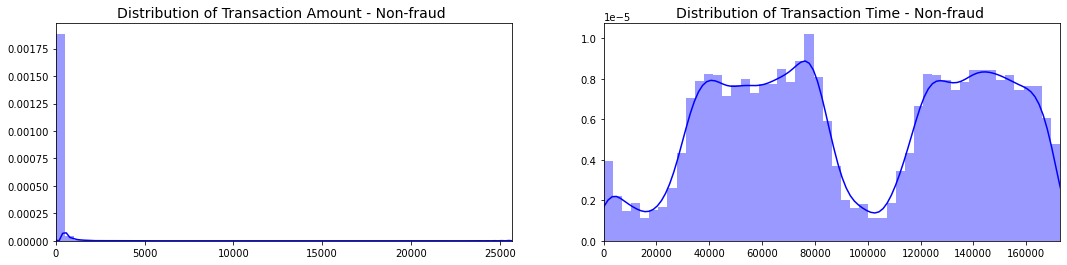

In [4]:
#Let's see the Amount's distribution and Transaction time for non-fraud class!
fig, ax = plt.subplots(1, 2, figsize=(18,4))
amount_val = df.loc[df['Class']==0]['Amount'].values
time_val = df.loc[df['Class']==0]['Time'].values
sns.distplot(amount_val, ax=ax[0], color='b')

ax[0].set_title('Distribution of Transaction Amount - Non-fraud ', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])
sns.distplot(time_val, ax=ax[1], color='b')

ax[1].set_title('Distribution of Transaction Time - Non-fraud ', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

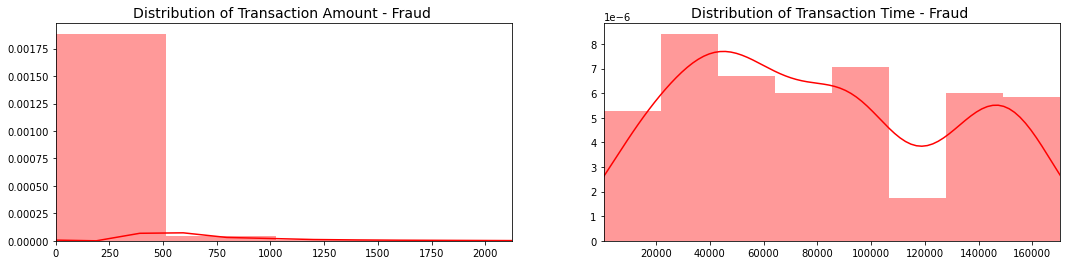

In [5]:
#Let's see the Amount's distribution and Transaction time for Fraud class!
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val_f = df.loc[df['Class']==1]['Amount'].values
time_val_f = df.loc[df['Class']==1]['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount - Fraud ', fontsize=14)
ax[0].set_xlim([min(amount_val_f), max(amount_val_f)])

sns.distplot(time_val_f, ax=ax[1], color='r')
ax[1].set_title('Distribution of Transaction Time - Fraud ', fontsize=14)
ax[1].set_xlim([min(time_val_f), max(time_val_f)])

plt.show()

In [6]:
#let's see the amont's mean for each class
print("Non-Fraud amont's mean: {}".format(df[df['Class']==0]['Amount'].mean()))
print("Non-Fraud amont's median: {}".format(df[df['Class']==0]['Amount'].median()))
print('--')
print("Fraud amont's mean: {}".format(df[df['Class']==1]['Amount'].mean()))
print("Fraud amont's median: {}".format(df[df['Class']==1]['Amount'].median()))

Non-Fraud amont's mean: 88.29102242225574
Non-Fraud amont's median: 22.0
--
Fraud amont's mean: 122.21132113821133
Fraud amont's median: 9.25


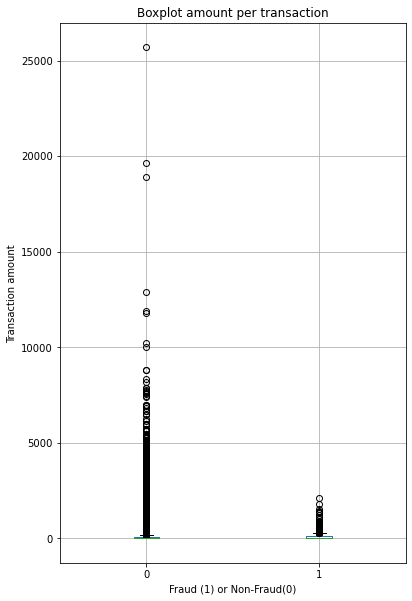

In [7]:
#Boxplot for amount's distribution for each class
df.boxplot(by='Class', column=['Amount'],grid=True,figsize=(6,10))
plt.title('Boxplot amount per transaction')
plt.suptitle('')
plt.ylabel('Transaction amount')
plt.xlabel('Fraud (1) or Non-Fraud(0)')
plt.show()

In [8]:
#let's see the number of features - subtracting the target
print('Number of features: {}'.format(len(df.columns)-1))

Number of features: 30


In [9]:
#defining our target!
X = df.drop('Class',axis=1)
y = df['Class']

In [10]:
#Split the X and Y into train and test partition! And looking for the distribution!
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print('Nº Non-Fraud train: {}'.format(y_train.value_counts()[0]))
print('Nº Fraud train: {}'.format(y_train.value_counts()[1]))
print('Fraud %: {}'.format(y_train.value_counts()[0]/len(y_train)))
print('-----------------')
print('Nº Non-Fraud test: {}'.format(y_test.value_counts()[0]))
print('Nº Fraud test: {}'.format(y_test.value_counts()[1]))
print('Fraud %: {}'.format(y_test.value_counts()[0]/len(y_test)))


Nº Non-Fraud train: 227451
Nº Fraud train: 394
Fraud %: 0.9982707542408216
-----------------
Nº Non-Fraud test: 56864
Nº Fraud test: 98
Fraud %: 0.9982795547909132


In [11]:
#using a simple Random Forest to find the best's features!
rf = RandomForestClassifier(random_state=42).fit(X_train,y_train)
imp = pd.DataFrame({'Features':X_train.columns, 'Importance': rf.feature_importances_})
print(imp.sort_values(by=['Importance'],ascending=False))

   Features  Importance
17      V17    0.157526
12      V12    0.134800
14      V14    0.124608
10      V10    0.081166
16      V16    0.074635
11      V11    0.057927
9        V9    0.034041
7        V7    0.029772
18      V18    0.028322
4        V4    0.026813
21      V21    0.018452
3        V3    0.017194
26      V26    0.017114
2        V2    0.014254
20      V20    0.014003
1        V1    0.013598
19      V19    0.013545
6        V6    0.012791
29   Amount    0.012721
8        V8    0.012556
15      V15    0.012203
0      Time    0.011629
5        V5    0.011041
22      V22    0.010928
27      V27    0.010803
24      V24    0.010626
28      V28    0.010427
13      V13    0.009855
25      V25    0.008379
23      V23    0.008271


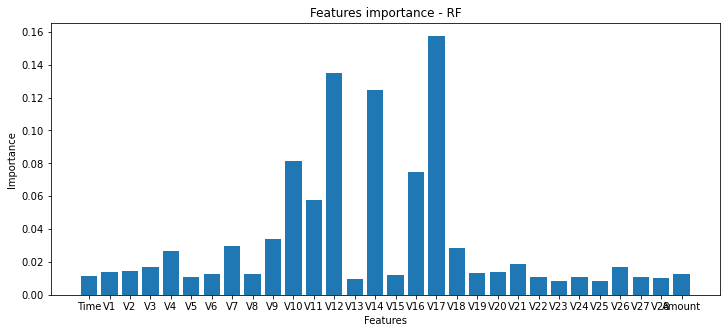

In [12]:
#Looking at the RF feature importance using bar chart!
plt.figure(figsize=(12,5))
plt.xticks(range(len(imp)), imp['Features'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Features importance - RF')
plt.bar(range(len(imp)), imp['Importance']);

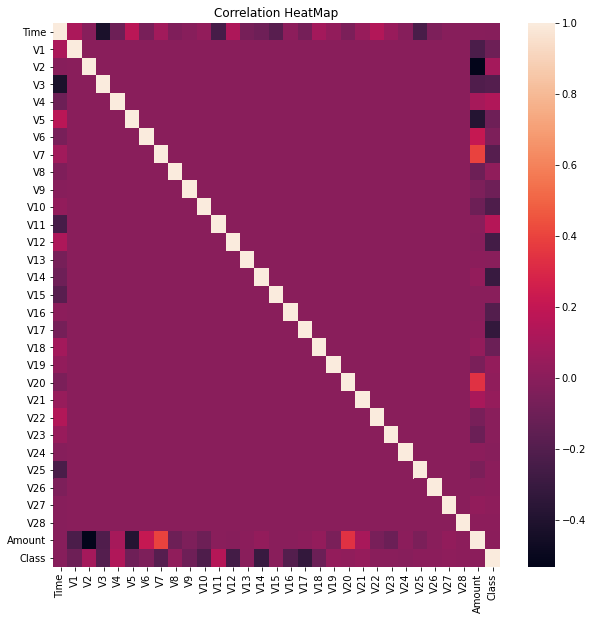

In [13]:
#let's see correlation heatmap
plt.figure(figsize=[10,10])
plt.title('Correlation HeatMap')
sns.heatmap(df.corr());

In [14]:
#lets see the correlation only for the target column!
df.corr()['Class'].sort_values()

V17      -0.326481
V14      -0.302544
V12      -0.260593
V10      -0.216883
V16      -0.196539
V3       -0.192961
V7       -0.187257
V18      -0.111485
V1       -0.101347
V9       -0.097733
V5       -0.094974
V6       -0.043643
Time     -0.012323
V24      -0.007221
V13      -0.004570
V15      -0.004223
V23      -0.002685
V22       0.000805
V25       0.003308
V26       0.004455
Amount    0.005632
V28       0.009536
V27       0.017580
V8        0.019875
V20       0.020090
V19       0.034783
V21       0.040413
V2        0.091289
V4        0.133447
V11       0.154876
Class     1.000000
Name: Class, dtype: float64

In [15]:
#lets use top 8 features and amount!
#This features were selected using RF importance and higher correlation with the target!
features = ['V17','V14','V12','V11','V16','V10','V4','V3', 'Amount']

In [16]:
#Creating the model - fitting and predicting also!
model = CatBoostClassifier(verbose=False,random_state=42)
model.fit(X_train[features],y_train)
y_pred_train = model.predict(X_train[features])
y_pred_test = model.predict(X_test[features])

In [17]:
print('\t\t\tTraining Set evaluation')
print(classification_report(y_pred_train,y_train))
print('\nConfusion Matrix')
print(confusion_matrix(y_pred_train,y_train))

			Training Set evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227483
           1       0.90      0.98      0.94       362

    accuracy                           1.00    227845
   macro avg       0.95      0.99      0.97    227845
weighted avg       1.00      1.00      1.00    227845


Confusion Matrix
[[227445     38]
 [     6    356]]


In [18]:
print('\t\t\tTest Set evaluation')
print(classification_report(y_pred_test,y_test))
print('\nConfusion Matrix')
print(confusion_matrix(y_pred_test,y_test))

			Test Set evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56879
           1       0.82      0.96      0.88        83

    accuracy                           1.00     56962
   macro avg       0.91      0.98      0.94     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix
[[56861    18]
 [    3    80]]


Confusion Matrix can be not meaningful so... let's see **Precision-Recall Curve (AUPRC)**

In [19]:
average_precision = average_precision_score(y_test, y_pred_test)

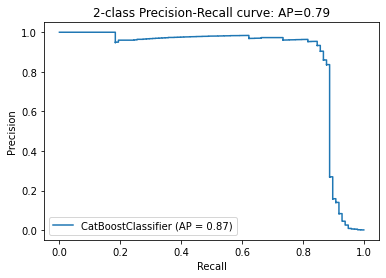

In [20]:
disp = plot_precision_recall_curve(model, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision));

The precision-recall curve shows the tradeoff between precision and recall for different threshold. **A high area under the curve represents both high recall and high precision**, where **high precision relates to a low false positive rate**, and **high recall relates to a low false negative rate**. **High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall)**.

In [21]:
#Let's check if the model is stable - using cross validation with 5 folds and scoring using F1 Score!
scores = cross_validate(model, X[features], y, cv=5, scoring=('f1'))

In [22]:
scores

{'fit_time': array([68.914433  , 71.17439461, 67.3056407 , 58.215343  , 53.40870214]),
 'score_time': array([0.07799578, 0.08403301, 0.08300138, 0.07899928, 0.08502412]),
 'test_score': array([0.76233184, 0.85227273, 0.71578947, 0.87777778, 0.81395349])}

In [23]:
print('F1 Score mean: {}, F1 Score Standard Deviation: {}'.format(round(scores['test_score'].mean(),3),round(scores['test_score'].std(),3)))

F1 Score mean: 0.804, F1 Score Standard Deviation: 0.059


# Evaluation! €

In [46]:
print("The model would have blocked (mean) : {}".format(locale.currency(
    round(df[df["Class"] == 1]["Amount"].describe()[1]*80, 2), grouping=True)))
print("------------------------------")
print("With the cost of : {}".format(locale.currency(
    round(df[df["Class"] == 0]["Amount"].describe()[1]*18, 2), grouping=True)))

The model would have blocked (mean) : 9.776,91 €
------------------------------
With the cost of : 1.589,24 €


In [47]:
df_test = X_test[features].copy()
df_test['Class'] = y_test.copy()

# Evaluation! € - Test Partition!

In [48]:
#Adding a new column to the dataset df_test!

df_test["Pred"] = model.predict(df_test[features])

In [49]:
print('Money amount in class Fraud: {}'.format(locale.currency(df_test[df_test["Class"] == 1]["Amount"].sum())))

Money amount in class Fraud: 16078,40 €


In [50]:
print('Money amount in class Fraud - Predicted: {}'.format(locale.currency(df_test[df_test["Pred"] == 1]["Amount"].sum())))

Money amount in class Fraud - Predicted: 12243,22 €


In [57]:
print("Total Value: {}\n".format(locale.currency(df_test['Amount'].sum(), grouping=True)))
print("Blocked Value: {}".format(locale.currency(df_test[(df_test["Pred"] == 1) & (df_test["Class"] == 1)]["Amount"].sum()
                                                      , grouping=True)))
print()
print("Total % (Correct Classification - Fraud class): {}".format(round(df_test[(df_test["Pred"] == 1) & (df_test["Class"] == 1)]["Amount"].sum()/
                                              df_test[df_test["Class"] == 1]["Amount"].sum()*100, 2)))
print()
print("False Negative (Amount) : {}".format(locale.currency(df_test[(df_test["Pred"] == 0) & (df_test["Class"] == 1)]["Amount"].sum()
                                                    , grouping=True)))
print("------------------------------")
print("False Positive (Amount): {}".format(locale.currency(df_test[(df_test["Pred"] == 1) & (df_test["Class"] == 0)]["Amount"].sum(), grouping=True)))
print("")
print("Total %  (Correct Classification - Non-Fraud class): {}".format(round(df_test[(df_test["Pred"] == 0) & (df_test["Class"] == 0)]["Amount"].sum()/
                                              df_test[df_test["Class"] == 0]["Amount"].sum()*100, 2)))

Total Value: 5.002.866,02 €

Blocked Value: 11.918,20 €

Total % (Correct Classification - Fraud class): 74.13

False Negative (Amount) : 4.160,20 €
------------------------------
False Positive (Amount): 325,02 €

Total %  (Correct Classification - Non-Fraud class): 99.99


- Blocked Value: Amount of money saved with the model!
- False Negative: Predicted as Non-Fraud but is Fraud
- False Positive: Predicted as Fraud but is Non-Fraud

## With the model we would have blocked `11.918,20 €` (74.13% of all fraud), with a loss of `4.160,20 €` with the cost of `325,02 €`.